# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
!pip install ta
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import ta

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
sns.set_style('white')

In [10]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [11]:
DATA_DIR = Path('/content/drive/MyDrive/ahfs')


In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2019'], :]
          .loc[lambda df: ~df.index.duplicated(), :])

In [16]:
before = len(prices.index.unique('ticker').unique())

### Remove symbols with missing values

In [17]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('ticker')
        .swaplevel())

TypeError: ignored

In [18]:
after = len(prices.index.unique('ticker').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,617 after: 2,248


### Keep most traded symbols

In [19]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()

In [20]:
prices = prices.loc[idx[keep, :], :]


TypeError: ignored

## Feature Engineering

### Compute period returns

In [21]:
intervals = [1, 5, 10, 21, 63]

In [22]:
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

TypeError: ignored

### Remove outliers

In [24]:
max_ret_by_sym = returns.groupby(level='ticker').max()

In [25]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.171666,0.351484,0.473315,0.626662,1.021824
std,0.085293,0.298160,0.535500,0.816274,1.507067
min,0.066822,0.105317,0.106830,0.130860,0.204479
50%,0.150599,0.253131,0.307138,0.389828,0.640128
90%,0.269886,0.625031,0.848966,1.066853,1.770603
95%,0.342345,0.936014,1.384150,1.688655,2.575105
97.5%,0.384632,1.360088,2.045741,2.889063,4.390628
99%,0.471793,1.668682,3.300744,4.627203,8.028316
99.5%,0.600000,1.958242,3.710301,5.666306,9.627482


In [26]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [27]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

58

In [28]:
prices = prices.drop(to_drop, level='ticker')


TypeError: ignored

### Calculate relative return percentiles

In [30]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [33]:
ppo = prices.groupby(level='ticker').close.apply(ta.momentum.ppo).to_frame('PPO')

#### Normalized Average True Range

In [35]:
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: ta.volatility.average_true_range(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [36]:
rsi = prices.groupby(level='ticker').close.apply(ta.momentum.rsi).to_frame('RSI')

#### Bollinger Bands

In [37]:
def get_bollinger(x):
    u = ta.volatility.bollinger_hband(x)
    m = ta.volatility.bollinger_mavg(x)
    l = ta.volatility.bollinger_lband(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [38]:
bbands = prices.groupby(level='ticker').close.apply(get_bollinger)

### Combine Features

In [39]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [40]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [41]:
data.bbu.corr(data.bbl, method='spearman')

-0.3720725458424279

### Plot Indicators for randomly sample ticker

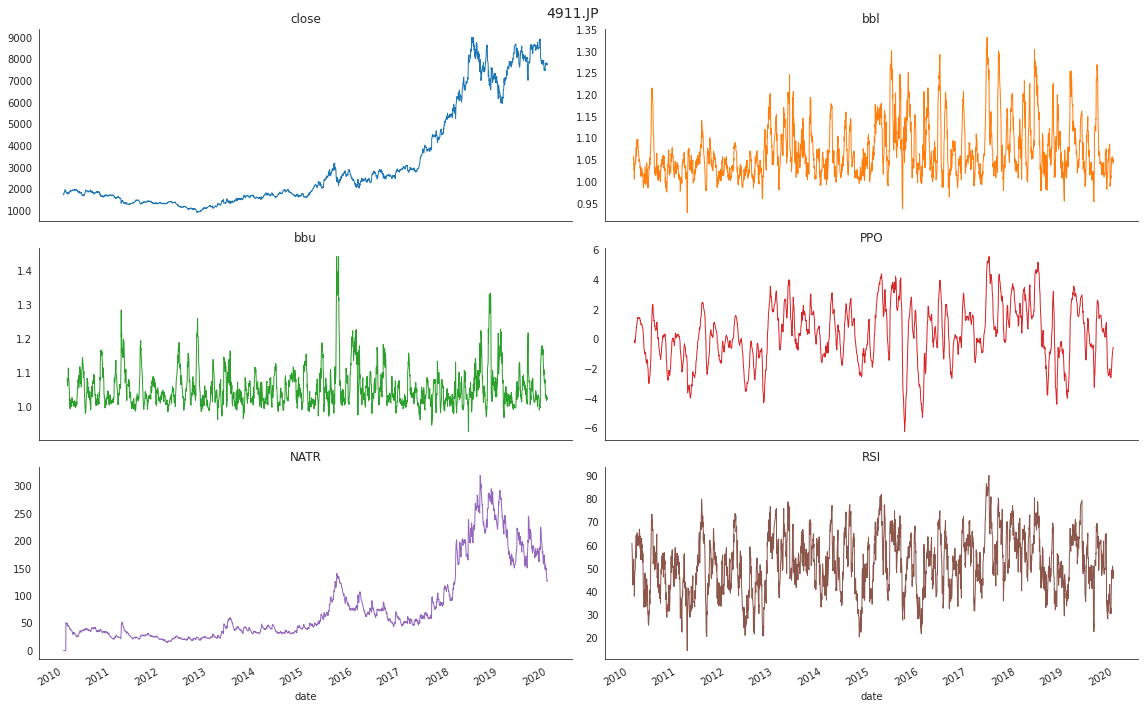

In [42]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [43]:
data = data.drop(prices.columns, axis=1)

### Create time period indicators

In [44]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [45]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

In [46]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2306958 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2306016 non-null  float64
 1   ret_rel_perc_1   2306016 non-null  float64
 2   ret_5            2302248 non-null  float64
 3   ret_rel_perc_5   2302248 non-null  float64
 4   ret_10           2297538 non-null  float64
 5   ret_rel_perc_10  2297538 non-null  float64
 6   ret_21           2287176 non-null  float64
 7   ret_rel_perc_21  2287176 non-null  float64
 8   ret_63           2247612 non-null  float64
 9   ret_rel_perc_63  2247612 non-null  float64
 10  PPO              2283408 non-null  float64
 11  NATR             2306958 non-null  float64
 12  RSI              2294712 non-null  float64
 13  bbl              2289060 non-null  float64
 14  bbu              2289060 non-nul

In [47]:
data.to_hdf('data.h5', 'stooq/japan/equities')